Each models is required to generate a stack ranking of all properties listed for sale in the database.

This script runs daily, reads in CSV files with a sorted order of homes (most attractive at the top to least attractive at the bottom), and a 'ypred' variable that reflects the scripts absolute metric (like P&L or probability of sale).

The script compares each list with homes that were sold, and identifies closed transactions ('positives') as well as the top 10 properties that each model identified that didn't sell ('negatives'). The remainder is considered 'control set'. 

For the overall data set, and specifically for each of those 3 groups, we output the average 'ypred' value, what number and percentage of homes sold from each.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
from slacker import Slacker
import json
import requests
from cloudinary.uploader import upload
from cloudinary.utils import cloudinary_url
from cloudinary.api import delete_resources_by_tag, resources_by_tag

csv_path = '/home/ilya/Code/rentalnerd/scraper/'
today = dt.date.today()


%matplotlib inline
        
# slack secrets (in your ~/.bashrc)
webhook_url = os.environ.get('SLACK_URL')
slacker = Slacker(os.environ.get('SLACK_TOKEN'))

# how old a target list to compare to the current target list
lag_days = 40

pd.set_option('display.max_colwidth', -1)
discount = 0.050

# to remove all the random far away areas - PHX only
zipcode_list = ['85006', '85007', '85008', '85009', '85013', '85015', '85016', '85017',
       '85018', '85019', '85020', '85021', '85022', '85023', '85024',
       '85027', '85028', '85029', '85031', '85033', '85035', '85037',
       '85040', '85041', '85043', '85044', '85048', '85050', '85051',
       '85053', '85085', '85086', '85087', '85118', '85138', '85139',
       '85142', '85143', '85202', '85203', '85204', '85205', '85206',
       '85207', '85209', '85210', '85212', '85213', '85215', '85224',
       '85225', '85226', '85233', '85234', '85248', '85249', '85250',
       '85251', '85253', '85254', '85255', '85257', '85258', '85262',
       '85266', '85286', '85295', '85296', '85297', '85298', '85301',
       '85302', '85303', '85304', '85305', '85306', '85308', '85310',
       '85323', '85326', '85331', '85335', '85339', '85340', '85351',
       '85353', '85355', '85373', '85374', '85375', '85382', '85383',
       '85388', '85390', '85392', '85396', '85704', '85705', '85706',
       '85711', '85712']

In [2]:
def plot_rounds(plot):
    # uploads the graph to the web and returns the URL
    
    fig = plot.get_figure()
    fig.tight_layout()
    fig.savefig('temp_plot.png')
    
    response = upload("temp_plot.png")
    url, options = cloudinary_url(response['public_id'],
        format = response['format'],
        crop = "fill")
    return url

In [3]:
def slack(text, url = None, title = None):
    print("Slacking: " + text)
    
    if url == None:
        data=json.dumps({"text": text})
    else:
        data = json.dumps( { "text": text, "attachments": [ { "fallback": "Model MAE"
                                           , "title": title
                                           , "image_url": url } ] } )
    
    response = requests.post(webhook_url, data , headers={'Content-Type': 'application/json'})
    if response.status_code != 200:
        raise ValueError('Request to slack returned an error %s, the response is:\n%s' % (response.status_code, response.text))


In [4]:
closed = pd.read_csv('CSV_backups/ALL-sales.csv',nrows=10000000, index_col=['property_id','transaction_id'])

/home/ilya/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (13,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
closed.head()

,,price,transaction_status,date_listed,date_closed,days_on_market,transaction_type,price_listed,price_closed,date_transacted_latest,fsbo,...,school_district_id_60.0,school_district_id_67.0,school_district_id_68.0,school_district_id_75.0,school_district_id_76.0,school_district_id_87.0,school_district_id_90.0,school_district_id_93.0,school_district_id_96.0,school_district_id_nan
property_id,transaction_id,,,,,,,,,,,,,,,,,,,,,
9020022,22741378,88000,closed,NaN,4506,NaN,sales,NaN,88000,2012-05-03,0.0,...,0,0,0,0,0,0,0,0,0,0
9020013,22741301,133900,closed,2012-02-07,4496,76.0,sales,133900.0,133900,2012-04-23,0.0,...,0,0,0,0,0,0,0,0,0,0
9020014,22741291,127900,closed,2011-07-17,4226,11.0,sales,149000.0,127900,2011-07-28,0.0,...,0,0,0,0,0,0,0,0,0,0
9020009,22741271,345000,closed,2014-08-01,5347,21.0,sales,349000.0,345000,2014-08-22,0.0,...,0,0,0,0,0,0,0,0,0,0
206421,22740884,182000,closed,NaN,4902,NaN,sales,NaN,182000,2013-06-03,0.0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# read in prior target list for backtesting purposes
model_results = np.empty([0,7])
for lag_days in range(1,2):
    print("Lag days %i\n\n" % lag_days)
    try:
        prior_target_list = pd.read_csv(csv_path + 'good_sell/gs_target_list_' + (today-dt.timedelta(days=lag_days)) \
                                    .strftime('%Y%m%d') + '.csv', index_col = [0,1]) \
                                    .rename(columns = { 'ypred' : 'good_sell_prob'})

        backtest = prior_target_list.join(closed[['price']], how="inner").sort_values(by='good_sell_prob',ascending=False)
        backtest['good_sell'] = (backtest.price >= (backtest.list * (1-discount)))
        y_all = prior_target_list.good_sell_prob.mean()
        y_sold = backtest.good_sell_prob.mean()

        pos_trigger = prior_target_list.good_sell_prob.quantile(0.75)
        slack("Prior target list length: %i\tNum sold: %i\tAvg good sell prob: %f\tAvg good sell prob of sold: %f" 
              % (len(prior_target_list.index), len(backtest.index),y_all, y_sold))

        num_pos = len(prior_target_list[prior_target_list.good_sell_prob > pos_trigger].index)
        positives = backtest[backtest.good_sell_prob > pos_trigger]
        y_pos = (-(positives.price - positives.list) / positives.list).median()
        num_sold = len(positives.index)
        if num_sold == 0:
            slack("Num of homes with good_sell_prob > %f: %i\tPerc of those sold: NONE\tMed disc to list: NA" % (pos_trigger, num_pos) )    
        else:
            slack("Num of homes with good_sell_prob > %f: %i\tPerc of those sold: %f\tMed disc to list: %f" 
                  % (pos_trigger, num_pos, num_sold / num_pos *  100, y_pos * 100))

        neg_trigger = prior_target_list.good_sell_prob.quantile(0.25)
        num_neg = len(prior_target_list[prior_target_list.good_sell_prob < neg_trigger].index)
        negatives = backtest[backtest.good_sell_prob < neg_trigger]
        y_neg = (-(negatives.price - negatives.list) / negatives.list).median()
        num_sold = len(negatives.index)

        if num_sold == 0:
            slack("Num of homes with good_sell_prob < %f: %i\tPerc of those sold: NONE\tMedian disc to list: NA" % (neg_trigger, num_neg))
        else:
            slack("Num of homes with good_sell_prob < %f: %i\tPerc of those sold: %f\tMedian disc to list:%f" 
                  % (neg_trigger, num_neg, len(negatives.index) / num_neg * 100, y_neg * 100))

        slack(backtest.to_string())
        backtest.to_csv("median_check.csv")
        # store results in arrays for graphing
        r = np.array([[lag_days, len(prior_target_list.index), len(backtest.index), num_sold / num_pos * 100, y_pos * 100, len(negatives.index) / num_neg * 100, y_neg * 100]])
        model_results = np.append(model_results,r,axis=0)
        
    except Exception as err:   
        print(err)

Lag days 1


Slacking: Prior target list length: 7336	Num sold: 7	Avg good sell prob: 0.422779	Avg good sell prob of sold: 0.422552
Slacking: Num of homes with good_sell_prob > 0.416209: 1558	Perc of those sold: 0.064185	Med disc to list: -0.571429
Slacking: Num of homes with good_sell_prob < 0.416209: 0	Perc of those sold: NONE	Median disc to list: NA
Slacking:                                                              address  zipcode  good_sell_prob    list                                                                                     url      lat     long date_listed transaction_date   price  good_sell
property_id transaction_id                                                                                                                                                                                                                                     
40413       22115312        3226 S 74th Ln, Phoenix, AZ 85043         85043    0.460611        175000  https://www.zillow.c

In [7]:
import matplotlib.pyplot as plt
index = pd.Index(model_results[:,0], names='lag_days')
graph_results = pd.DataFrame(model_results[:,1:],index=index,columns=['num_for_sale', 'num_sold', 'perc_sold_good','discount_good', 'perc_sold_bad', 'discount_bad']) \
                    .sort_index(ascending=False)

graph_results.head()

,num_for_sale,num_sold,perc_sold_good,discount_good,perc_sold_bad,discount_bad


In [8]:
# graph_results[['num_for_sale', 'discount_good','discount_bad']].plot(figsize=(14,14),secondary_y='num_for_sale')

In [9]:
# read in prior target list for backtesting purposes
prior_target_list = pd.read_csv(csv_path + 'value_buy/vb_target_list_' + (today-dt.timedelta(days=lag_days)) \
                                .strftime('%Y%m%d') + '.csv', index_col = [0,1]) \
                                .rename(columns = { 'ypred' : 'pnl'})

try:
    backtest = prior_target_list.join(closed['price'], how="inner").sort_values(by='pnl',ascending=False)
    backtest['good_sell'] = (backtest.price >= (backtest.list * (1-discount)))
    avg_pnl = backtest.pnl.mean()
    predicted_price = backtest.predicted_price.mean()
    sale_price = backtest.price.mean()

    slack("Prior target list length: %i\tNum sold: %i\tAvg P&L: %f\tAvg predict price: %f\tAvg sale price: %f" 
          % (len(prior_target_list.index), len(backtest.index),y_all, predicted_price, sale_price))

    pos_trigger = -10000
    num_pos = len(prior_target_list[prior_target_list.pnl > pos_trigger].index)
    positives = backtest[backtest.pnl > pos_trigger]
    y_pos = (-(positives.price - positives.list) / positives.list).mean()
    num_sold = len(positives.index)
    if num_sold == 0:
        slack("Num of homes with pnl > %f: %i\tPerc of those sold: NONE\tAvg disc to list: NA" % (pos_trigger, num_pos) )    
    else:
        slack("Num of homes with pnl > %f: %i\tPerc of those sold: %f\tAvg disc to list: %f" 
              % (pos_trigger, num_pos, num_sold / num_pos, y_pos))

    neg_trigger = -30000
    num_neg = len(prior_target_list[prior_target_list.pnl < neg_trigger].index)
    negatives = backtest[backtest.pnl < neg_trigger]
    y_neg = (-(negatives.price - negatives.list) / negatives.list).mean()
    num_sold = len(negatives.index)

    if num_sold == 0:
        slack("Num of homes with pnl < %f: %i\tPerc of those sold: NONE\tAvg disc to list: NA" % (neg_trigger, num_neg))
    else:
        slack("Num of homes with pnl < %f: %i\tPerc of those sold: %f\tAvg disc to list:%f" 
              % (neg_trigger, num_neg, len(negatives.index) / num_neg, y_neg))

    slack(backtest.to_string())
except Exception as err:   
    slack("No homes sold since last run")

Slacking: Prior target list length: 7336	Num sold: 7	Avg P&L: 0.422779	Avg predict price: 208443.770089	Avg sale price: 218028.571429
Slacking: Num of homes with pnl > -10000.000000: 3246	Perc of those sold: 0.001232	Avg disc to list: 0.039575
Slacking: Num of homes with pnl < -30000.000000: 3250	Perc of those sold: 0.000615	Avg disc to list:0.018607
Slacking:                                                              address  zipcode            pnl  predicted_price    list                                                                                     url   price  good_sell
property_id transaction_id                                                                                                                                                                                                      
9006630     22719287        4201 N 27th Dr, Phoenix, AZ 85017         85017    49701.531250   165601.531250    115900  https://www.zillow.com/homedetails/4201-N-27th-Dr-Phoenix-AZ-85017/7

In [10]:
vb = pd.read_csv('value_buy/vb_target_list_' + today.strftime('%Y%m%d') + '.csv', index_col = ['property_id','transaction_id']) \
       .drop(['address','zipcode', 'url','list'],axis=1) \
       .rename(columns = { 'ypred': 'pnl'}) \
       .drop_duplicates()
    
gs = pd.read_csv('good_sell/gs_target_list_'  + today.strftime('%Y%m%d') + '.csv', index_col = ['property_id','transaction_id'])  \
       .rename(columns = { 'ypred' : 'good_sell_prob'}) \
       .drop_duplicates()
        
vb = vb[~vb.index.duplicated(keep='first')]
gs = gs[~gs.index.duplicated(keep='first')]
    
print("Len of value buy\t%i" % len(vb.index))
print("Len of good sell\t%i" % len(gs.index))

c = pd.concat([vb,gs],axis=1, join='inner')

c['pnl_percent'] = (c.pnl / c.list)

c = c[(c.list < 250000) & (c.list > 100000)  \
      & (~c.address.str.contains("Rent|rent|LOT|#|Sun City"))] 

Len of value buy	7504
Len of good sell	7522


/home/ilya/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Slacking: 


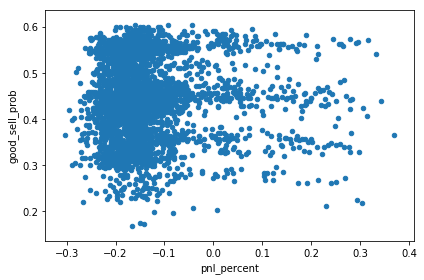

In [11]:
url = plot_rounds(c.query('good_sell_prob > 0.00').plot.scatter(x='pnl_percent', y='good_sell_prob'))
slack("", url, "Model Correlation")

In [12]:
# ran both data datasets and combine to create an equally weighted ensemble ranking
c["pnl_rank"] = c.pnl.rank(ascending=False)
c["gs_rank"] = c.good_sell_prob.rank(ascending=False)
c["rank"] = (c.pnl_rank + c.gs_rank)
c["zipcode"] = c.zipcode.apply(str)

# filter the output to remove duds
d = c[(c.pnl_percent > -0.2) & (c.good_sell_prob > 0.4) & (c.zipcode.isin(zipcode_list))]

In [13]:
d = c.sort_values("rank").nsmallest(20, "gs_rank")

file = csv_path + 'ensemble/comb_target_list_' + today.strftime('%Y%m%d') + '.csv'
np.round(d[['address', 'zipcode','list','predicted_price','pnl_percent','good_sell_prob','rank','url']], 4).to_csv(file)

slacker.files.upload(file, channels='#progress')

In [14]:
for_sale = pd.read_csv('CSV_backups/ALL-for_sale.csv', index_col=['property_id','transaction_id'])
for_sale['zipcode'] = for_sale.zipcode.apply(str)

/home/ilya/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
from math import radians, cos, sin, asin, sqrt
def haversine(row, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    lon1 = row.longitude
    lat1 = row.latitude
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km / 1.60934 # convert to miles

In [16]:
for r, target in d.iterrows():
    print(target.name[0])
    print(target.address)
    target.longitude = for_sale.loc[target.name].longitude
    target.latitude = for_sale.loc[target.name].latitude
    
    # get all properties listed for sale in the same zipcode as our target
    z = for_sale[(for_sale.zipcode == target.zipcode)]
    print(len(z.longitude))
    
    z['dist'] = z.apply(haversine, lon2 = target.longitude, lat2 = target.latitude, axis=1)
    print(z[['address','dist']].nsmallest(5,'dist'))
    

/home/ilya/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


42157
6602 W Papago St, Phoenix, AZ 85043 
234
                                                          address      dist
property_id transaction_id                                                 
42157       22540803        6602 W Papago St, Phoenix, AZ 85043    0.000000
350991      17868215        6522 W Cocopah St, Phoenix, AZ 85043   0.168946
342847      22613221        1702 S 64th Ave, Phoenix, AZ 85043     0.230133
349978      22399539        6342 W Sonora St, Phoenix, AZ 85043    0.238724
342960      22686672        1722 S 64th Ave, Phoenix, AZ 85043     0.264543
360963
8504 W Taylor St, Tolleson, AZ 85353 
143
                                                               address  \
property_id transaction_id                                               
360963      22641528        8504 W Taylor St, Tolleson, AZ 85353         
7404697     22436358        130 N 86th Ln, Tolleson, AZ 85353            
9012601     22733181        8709 W C P Hayes Dr, Tolleson, AZ 85353      
89

In [17]:
d

,,pnl,predicted_price,address,zipcode,good_sell_prob,list,url,lat,long,date_listed,transaction_date,pnl_percent,pnl_rank,gs_rank,rank
property_id,transaction_id,,,,,,,,,,,,,,,
42157,22540803,-7020.921875,149879.078125,"6602 W Papago St, Phoenix, AZ 85043",85043,0.603262,156900,https://www.zillow.com/homedetails/6602-W-Papago-St-Phoenix-AZ-85043/7499905_zpid/,33.4352,-112.201,2017-08-17,2017-08-17,-0.044748,420.0,2.0,422.0
360963,22641528,-14819.125000,145080.875000,"8504 W Taylor St, Tolleson, AZ 85353",85353,0.603262,159900,https://www.zillow.com/homedetails/8504-W-Taylor-St-Tolleson-AZ-85353/7476498_zpid/,33.4528,-112.244,2017-09-08,2017-09-08,-0.092677,651.0,2.0,653.0
445116,22669295,-36657.937500,193242.062500,"4623 N 99th Dr, Phoenix, AZ 85037",85037,0.603262,229900,https://www.zillow.com/homedetails/4623-N-99th-Dr-Phoenix-AZ-85037/7484459_zpid/,33.5017,-112.273,2017-09-08,2017-09-08,-0.159452,2986.0,2.0,2988.0
8991089,22517320,-21931.437500,178068.562500,"9941 W Hilton Ave, Tolleson, AZ 85353",85353,0.598850,200000,https://www.zillow.com/homedetails/9941-W-Hilton-Ave-Tolleson-AZ-85353/2093083273_zpid/,33.4263,-112.275,2017-08-17,2017-08-17,-0.109657,1040.0,7.5,1047.5
365924,22576385,-22793.859375,177106.140625,"9933 W Wood St, Tolleson, AZ 85353",85353,0.598850,199900,https://www.zillow.com/homedetails/9933-W-Wood-St-Tolleson-AZ-85353/88795745_zpid/,33.4078,-112.274,2017-08-25,2017-08-25,-0.114026,1110.0,7.5,1117.5
7400587,22528918,-25552.093750,151447.906250,"7421 W Darrel Rd, Laveen, AZ 85339",85339,0.598850,177000,https://www.zillow.com/homedetails/7421-W-Darrel-Rd-Laveen-AZ-85339/88785132_zpid/,33.3831,-112.218,2017-08-19,2017-08-19,-0.144362,1427.5,7.5,1435.0
8954173,22613302,-27225.265625,177674.734375,"8213 W Wood Ln, Phoenix, AZ 85043",85043,0.598850,204900,https://www.zillow.com/homedetails/8213-W-Wood-Ln-Phoenix-AZ-85043/95184242_zpid/,33.4100,-112.229,2017-09-01,2017-09-01,-0.132871,1652.0,7.5,1659.5
8998064,22576381,-29636.500000,167363.500000,"8754 W Riverside Ave, Tolleson, AZ 85353",85353,0.598850,197000,https://www.zillow.com/homedetails/8754-W-Riverside-Ave-Tolleson-AZ-85353/95164828_zpid/,33.4159,-112.249,2017-08-25,2017-08-25,-0.150439,1996.0,7.5,2003.5
9002577,22613295,-40381.312500,184518.687500,"8136 W Wood Ln, Phoenix, AZ 85043",85043,0.598850,224900,https://www.zillow.com/homedetails/8136-W-Wood-Ln-Phoenix-AZ-85043/95157310_zpid/,33.4100,-112.229,2017-09-01,2017-09-01,-0.179552,3386.0,7.5,3393.5


In [18]:
d.head()

,,pnl,predicted_price,address,zipcode,good_sell_prob,list,url,lat,long,date_listed,transaction_date,pnl_percent,pnl_rank,gs_rank,rank
property_id,transaction_id,,,,,,,,,,,,,,,
42157,22540803,-7020.921875,149879.078125,"6602 W Papago St, Phoenix, AZ 85043",85043,0.603262,156900,https://www.zillow.com/homedetails/6602-W-Papago-St-Phoenix-AZ-85043/7499905_zpid/,33.4352,-112.201,2017-08-17,2017-08-17,-0.044748,420.0,2.0,422.0
360963,22641528,-14819.125000,145080.875000,"8504 W Taylor St, Tolleson, AZ 85353",85353,0.603262,159900,https://www.zillow.com/homedetails/8504-W-Taylor-St-Tolleson-AZ-85353/7476498_zpid/,33.4528,-112.244,2017-09-08,2017-09-08,-0.092677,651.0,2.0,653.0
445116,22669295,-36657.937500,193242.062500,"4623 N 99th Dr, Phoenix, AZ 85037",85037,0.603262,229900,https://www.zillow.com/homedetails/4623-N-99th-Dr-Phoenix-AZ-85037/7484459_zpid/,33.5017,-112.273,2017-09-08,2017-09-08,-0.159452,2986.0,2.0,2988.0
8991089,22517320,-21931.437500,178068.562500,"9941 W Hilton Ave, Tolleson, AZ 85353",85353,0.598850,200000,https://www.zillow.com/homedetails/9941-W-Hilton-Ave-Tolleson-AZ-85353/2093083273_zpid/,33.4263,-112.275,2017-08-17,2017-08-17,-0.109657,1040.0,7.5,1047.5
365924,22576385,-22793.859375,177106.140625,"9933 W Wood St, Tolleson, AZ 85353",85353,0.598850,199900,https://www.zillow.com/homedetails/9933-W-Wood-St-Tolleson-AZ-85353/88795745_zpid/,33.4078,-112.274,2017-08-25,2017-08-25,-0.114026,1110.0,7.5,1117.5
